    # Method 1: Filtered Back-Projection (FBP)
## Classical CT Reconstruction Baseline

This notebook implements FBP as the baseline method for comparison with iterative and deep learning approaches.

**Pipeline:**
```
Low-dose Sinogram → FBP → Reconstructed CT Image
```

---

    ## 1. Setup and Imports

In [32]:
    # Install required packages
!pip install numpy h5py scikit-image scipy matplotlib pandas tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [33]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from skimage.transform import iradon
from scipy.ndimage import zoom
import pandas as pd
import json
from datetime import datetime
from tqdm import tqdm

    ## 2. Configuration

In [34]:
    # ===========================
# CONFIGURATION
# ===========================

# Data paths
DATA_DIR = Path("../data/lodopab")  # Update for Lambda Labs
OUTPUT_DIR = Path("../data/results/fbp")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# FBP parameters
FBP_CONFIG = {
    'filter_name': 'ramp',  # Options: 'ramp', 'shepp-logan', 'cosine', 'hamming', 'hann'
    'interpolation': 'linear',
    'circle': True,
    'num_test_samples': 128,  # None = all samples, or set number for subset
}

print("Configuration:")
print(f"  Data directory: {DATA_DIR}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Filter: {FBP_CONFIG['filter_name']}")
print(f"  Circle constraint: {FBP_CONFIG['circle']}")

Configuration:
  Data directory: ../data/lodopab
  Output directory: ../data/results/fbp
  Filter: ramp
  Circle constraint: True


    ## 3. FBP Reconstruction Function

In [35]:
def fbp_reconstruct(sinogram, filter_name='ramp', circle=True):
    """
    Filtered Back-Projection reconstruction
    
    Parameters:
    -----------
    sinogram : np.ndarray
        Sinogram of shape (1000, 513) - LoDoPaB format
    filter_name : str
        Filter to use: 'ramp', 'shepp-logan', 'cosine', 'hamming', 'hann'
    circle : bool
        Whether to assume circular object
    
    Returns:
    --------
    reconstructed : np.ndarray
        Reconstructed CT image of shape (362, 362)
    """
    # Transpose sinogram for iradon
    # LoDoPaB: (1000, 513) = (angles, detectors)
    # iradon expects: (detectors, angles)
    sinogram_transposed = sinogram.T
    
    # Define projection angles (0 to 180 degrees, 1000 angles)
    theta = np.linspace(0, 180, sinogram.shape[0], endpoint=False)
    
    # Perform FBP
    reconstructed = iradon(
        sinogram_transposed,
        theta=theta,
        filter_name=filter_name,
        interpolation='linear',
        circle=False,
        output_size= 362
    )
    
    # Resize to match ground truth size (362x362)
    if reconstructed.shape != (362, 362):
        scale_y = 362 / reconstructed.shape[0]
        scale_x = 362 / reconstructed.shape[1]
        reconstructed = zoom(reconstructed, (scale_y, scale_x), order=1)

    reconstructed = np.rot90(reconstructed, k=-1)
    return reconstructed.astype(np.float32)


# Test the function
print("Testing FBP reconstruction...")
test_sinogram = np.random.randn(1000, 513).astype(np.float32)
test_result = fbp_reconstruct(test_sinogram)
print(f"✓ FBP test successful! Output shape: {test_result.shape}")

Testing FBP reconstruction...
✓ FBP test successful! Output shape: (362, 362)


    ## 4. Evaluation Metrics

In [36]:
def calculate_psnr(img1, img2, data_range=1.0):
    """
    Calculate Peak Signal-to-Noise Ratio (PSNR)
    Higher is better
    """
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(data_range / np.sqrt(mse))


def calculate_ssim(img1, img2, data_range=1.0):
    """
    Calculate Structural Similarity Index (SSIM)
    Range: [-1, 1], higher is better
    """
    from skimage.metrics import structural_similarity
    return structural_similarity(img1, img2, data_range=data_range)


def calculate_nrmse(img1, img2):
    """
    Calculate Normalized Root Mean Square Error (NRMSE)
    Lower is better
    """
    rmse = np.sqrt(np.mean((img1 - img2) ** 2))
    nrmse = rmse / (img2.max() - img2.min())
    return nrmse


def normalize_image(img):
    """Normalize image to [0, 1]"""
    img_min = img.min()
    img_max = img.max()
    if img_max - img_min > 1e-8:
        return (img - img_min) / (img_max - img_min)
    return img


print("Evaluation metrics defined:")
print("  - PSNR (Peak Signal-to-Noise Ratio)")
print("  - SSIM (Structural Similarity Index)")
print("  - NRMSE (Normalized Root Mean Square Error)")

Evaluation metrics defined:
  - PSNR (Peak Signal-to-Noise Ratio)
  - SSIM (Structural Similarity Index)
  - NRMSE (Normalized Root Mean Square Error)


    ## 5. Load Test Data

In [37]:
test_obs_files = sorted(list(DATA_DIR.glob("observation_test_*.hdf5")))
test_gt_files = sorted(list(DATA_DIR.glob("ground_truth_test_*.hdf5")))

test_obs_files = test_obs_files[:1]  # Only first file
test_gt_files = test_gt_files[:1]    # Only first file
print(f"\nFound {len(test_obs_files)} observation files")
print(f"Found {len(test_gt_files)} ground truth files")

if not test_obs_files or not test_gt_files:
    print("\nERROR: No test files found!")
    print("Please check your data directory path.")
else:
    # Count total samples
    total_samples = 0
    for f in test_obs_files:
        with h5py.File(f, 'r') as hf:
            total_samples += hf['data'].shape[0]
    
    print(f"\nTotal test samples: {total_samples}")
    
    if FBP_CONFIG['num_test_samples']:
        print(f"Will process: {FBP_CONFIG['num_test_samples']} samples (subset)")
    else:
        print(f"Will process: All {total_samples} samples")


Found 1 observation files
Found 1 ground truth files

Total test samples: 128
Will process: 128 samples (subset)


    ## 6. Run FBP on Test Set

In [38]:
# Results storage
results = {
    'sample_id': [],
    'psnr': [],
    'ssim': [],
    'nrmse': [],
    'file_idx': [],
    'local_idx': []
}

# Process all test samples
sample_count = 0
max_samples = FBP_CONFIG['num_test_samples'] if FBP_CONFIG['num_test_samples'] else float('inf')

print("\nRunning FBP reconstruction on test set...")
print("="*60)

for file_idx, (obs_file, gt_file) in enumerate(zip(test_obs_files, test_gt_files)):
    
    with h5py.File(obs_file, 'r') as f_obs, h5py.File(gt_file, 'r') as f_gt:
        
        num_samples_in_file = f_obs['data'].shape[0]
        
        # Progress bar for this file
        pbar = tqdm(range(num_samples_in_file), desc=f"File {file_idx+1}/{len(test_obs_files)}")
        
        for local_idx in pbar:
            if sample_count >= max_samples:
                break
            
            # Load data
            sinogram = f_obs['data'][local_idx].astype(np.float32)
            ground_truth = f_gt['data'][local_idx].astype(np.float32)
            
            # FBP reconstruction
            reconstructed = fbp_reconstruct(
                sinogram,
                filter_name=FBP_CONFIG['filter_name'],
                circle=FBP_CONFIG['circle']
            )
            
            # Normalize both images
            reconstructed_norm = normalize_image(reconstructed)
            ground_truth_norm = normalize_image(ground_truth)
            
            # Calculate metrics
            psnr = calculate_psnr(reconstructed_norm, ground_truth_norm)
            ssim = calculate_ssim(reconstructed_norm, ground_truth_norm)
            nrmse = calculate_nrmse(reconstructed_norm, ground_truth_norm)
            
            # Store results
            results['sample_id'].append(sample_count)
            results['psnr'].append(psnr)
            results['ssim'].append(ssim)
            results['nrmse'].append(nrmse)
            results['file_idx'].append(int(file_idx))
            results['local_idx'].append(int(local_idx))
            
            # Update progress bar
            pbar.set_postfix({
                'PSNR': f"{psnr:.2f}",
                'SSIM': f"{ssim:.3f}"
            })
            
            sample_count += 1
    
    if sample_count >= max_samples:
        break

print("\n" + "="*60)
print(f"✓ Processed {sample_count} samples")


Running FBP reconstruction on test set...


File 1/1: 100%|██████████| 128/128 [02:33<00:00,  1.20s/it, PSNR=19.51, SSIM=0.320]


✓ Processed 128 samples


    ## 7. Calculate Summary Statistics

In [39]:
    # Convert to DataFrame
df_results = pd.DataFrame(results)

# Calculate statistics
summary = {
    'method': 'FBP',
    'filter': FBP_CONFIG['filter_name'],
    'num_samples': len(df_results),
    'psnr_mean': float(df_results['psnr'].mean()),
    'psnr_std': float(df_results['psnr'].std()),
    'psnr_min': float(df_results['psnr'].min()),
    'psnr_max': float(df_results['psnr'].max()),
    'ssim_mean': float(df_results['ssim'].mean()),
    'ssim_std': float(df_results['ssim'].std()),
    'ssim_min': float(df_results['ssim'].min()),
    'ssim_max': float(df_results['ssim'].max()),
    'nrmse_mean': float(df_results['nrmse'].mean()),
    'nrmse_std': float(df_results['nrmse'].std()),
    'timestamp': datetime.now().isoformat()
}

# Print summary
print("\n" + "="*60)
print("FBP RECONSTRUCTION RESULTS")
print("="*60)
print(f"Method: {summary['method']}")
print(f"Filter: {summary['filter']}")
print(f"Samples: {summary['num_samples']}")
print()
print(f"PSNR:  {summary['psnr_mean']:.2f} ± {summary['psnr_std']:.2f} dB")
print(f"       Range: [{summary['psnr_min']:.2f}, {summary['psnr_max']:.2f}]")
print()
print(f"SSIM:  {summary['ssim_mean']:.4f} ± {summary['ssim_std']:.4f}")
print(f"       Range: [{summary['ssim_min']:.4f}, {summary['ssim_max']:.4f}]")
print()
print(f"NRMSE: {summary['nrmse_mean']:.4f} ± {summary['nrmse_std']:.4f}")
print("="*60)


FBP RECONSTRUCTION RESULTS
Method: FBP
Filter: ramp
Samples: 128

PSNR:  18.90 ± 1.64 dB
       Range: [13.31, 24.23]

SSIM:  0.3298 ± 0.0884
       Range: [0.1424, 0.5160]

NRMSE: 0.1155 ± 0.0222


    ## 8. Save Results

In [40]:
    # Save detailed results
df_results.to_csv(OUTPUT_DIR / 'fbp_detailed_results.csv', index=False)
print(f"Saved detailed results to: {OUTPUT_DIR / 'fbp_detailed_results.csv'}")

# Save summary
with open(OUTPUT_DIR / 'fbp_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print(f"Saved summary to: {OUTPUT_DIR / 'fbp_summary.json'}")

Saved detailed results to: ../data/results/fbp/fbp_detailed_results.csv
Saved summary to: ../data/results/fbp/fbp_summary.json


    ## 9. Visualize Results

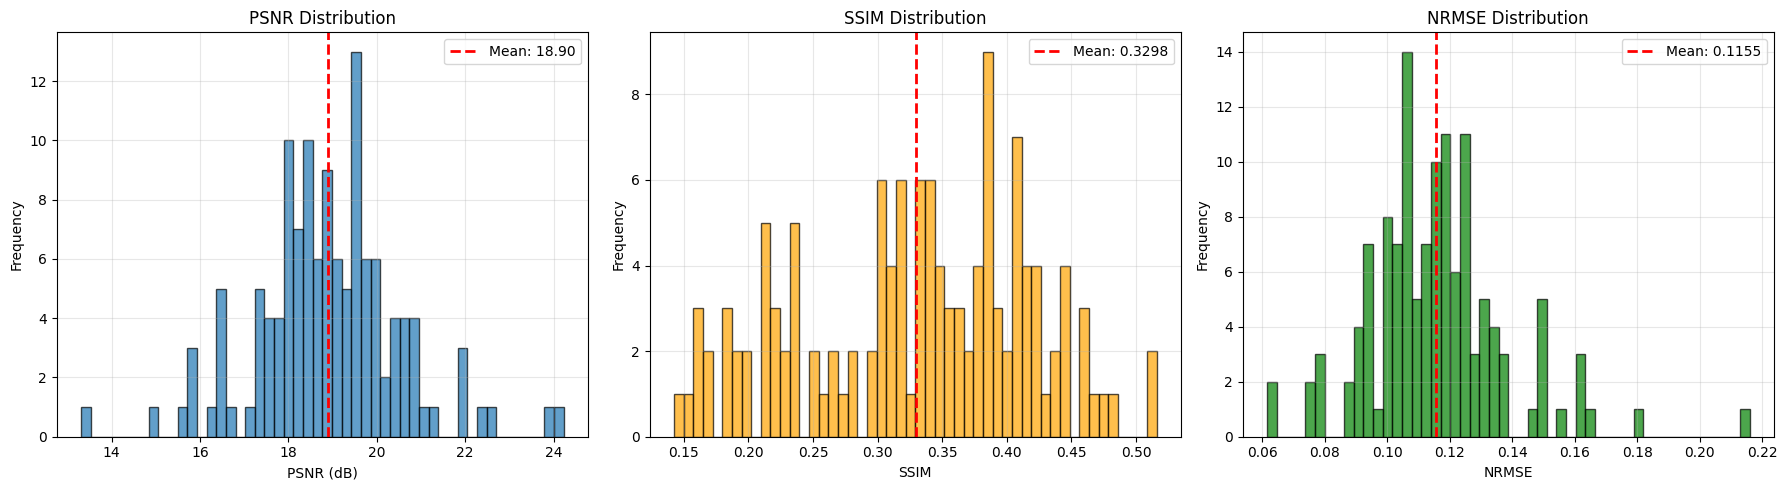

Saved plot to: ../data/results/fbp/fbp_metrics_distribution.png


In [41]:
    # Plot metric distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PSNR
axes[0].hist(df_results['psnr'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(summary['psnr_mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {summary['psnr_mean']:.2f}")
axes[0].set_xlabel('PSNR (dB)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('PSNR Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# SSIM
axes[1].hist(df_results['ssim'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(summary['ssim_mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {summary['ssim_mean']:.4f}")
axes[1].set_xlabel('SSIM')
axes[1].set_ylabel('Frequency')
axes[1].set_title('SSIM Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# NRMSE
axes[2].hist(df_results['nrmse'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].axvline(summary['nrmse_mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {summary['nrmse_mean']:.4f}")
axes[2].set_xlabel('NRMSE')
axes[2].set_ylabel('Frequency')
axes[2].set_title('NRMSE Distribution')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fbp_metrics_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {OUTPUT_DIR / 'fbp_metrics_distribution.png'}")

    ## 10. Visualize Sample Reconstructions

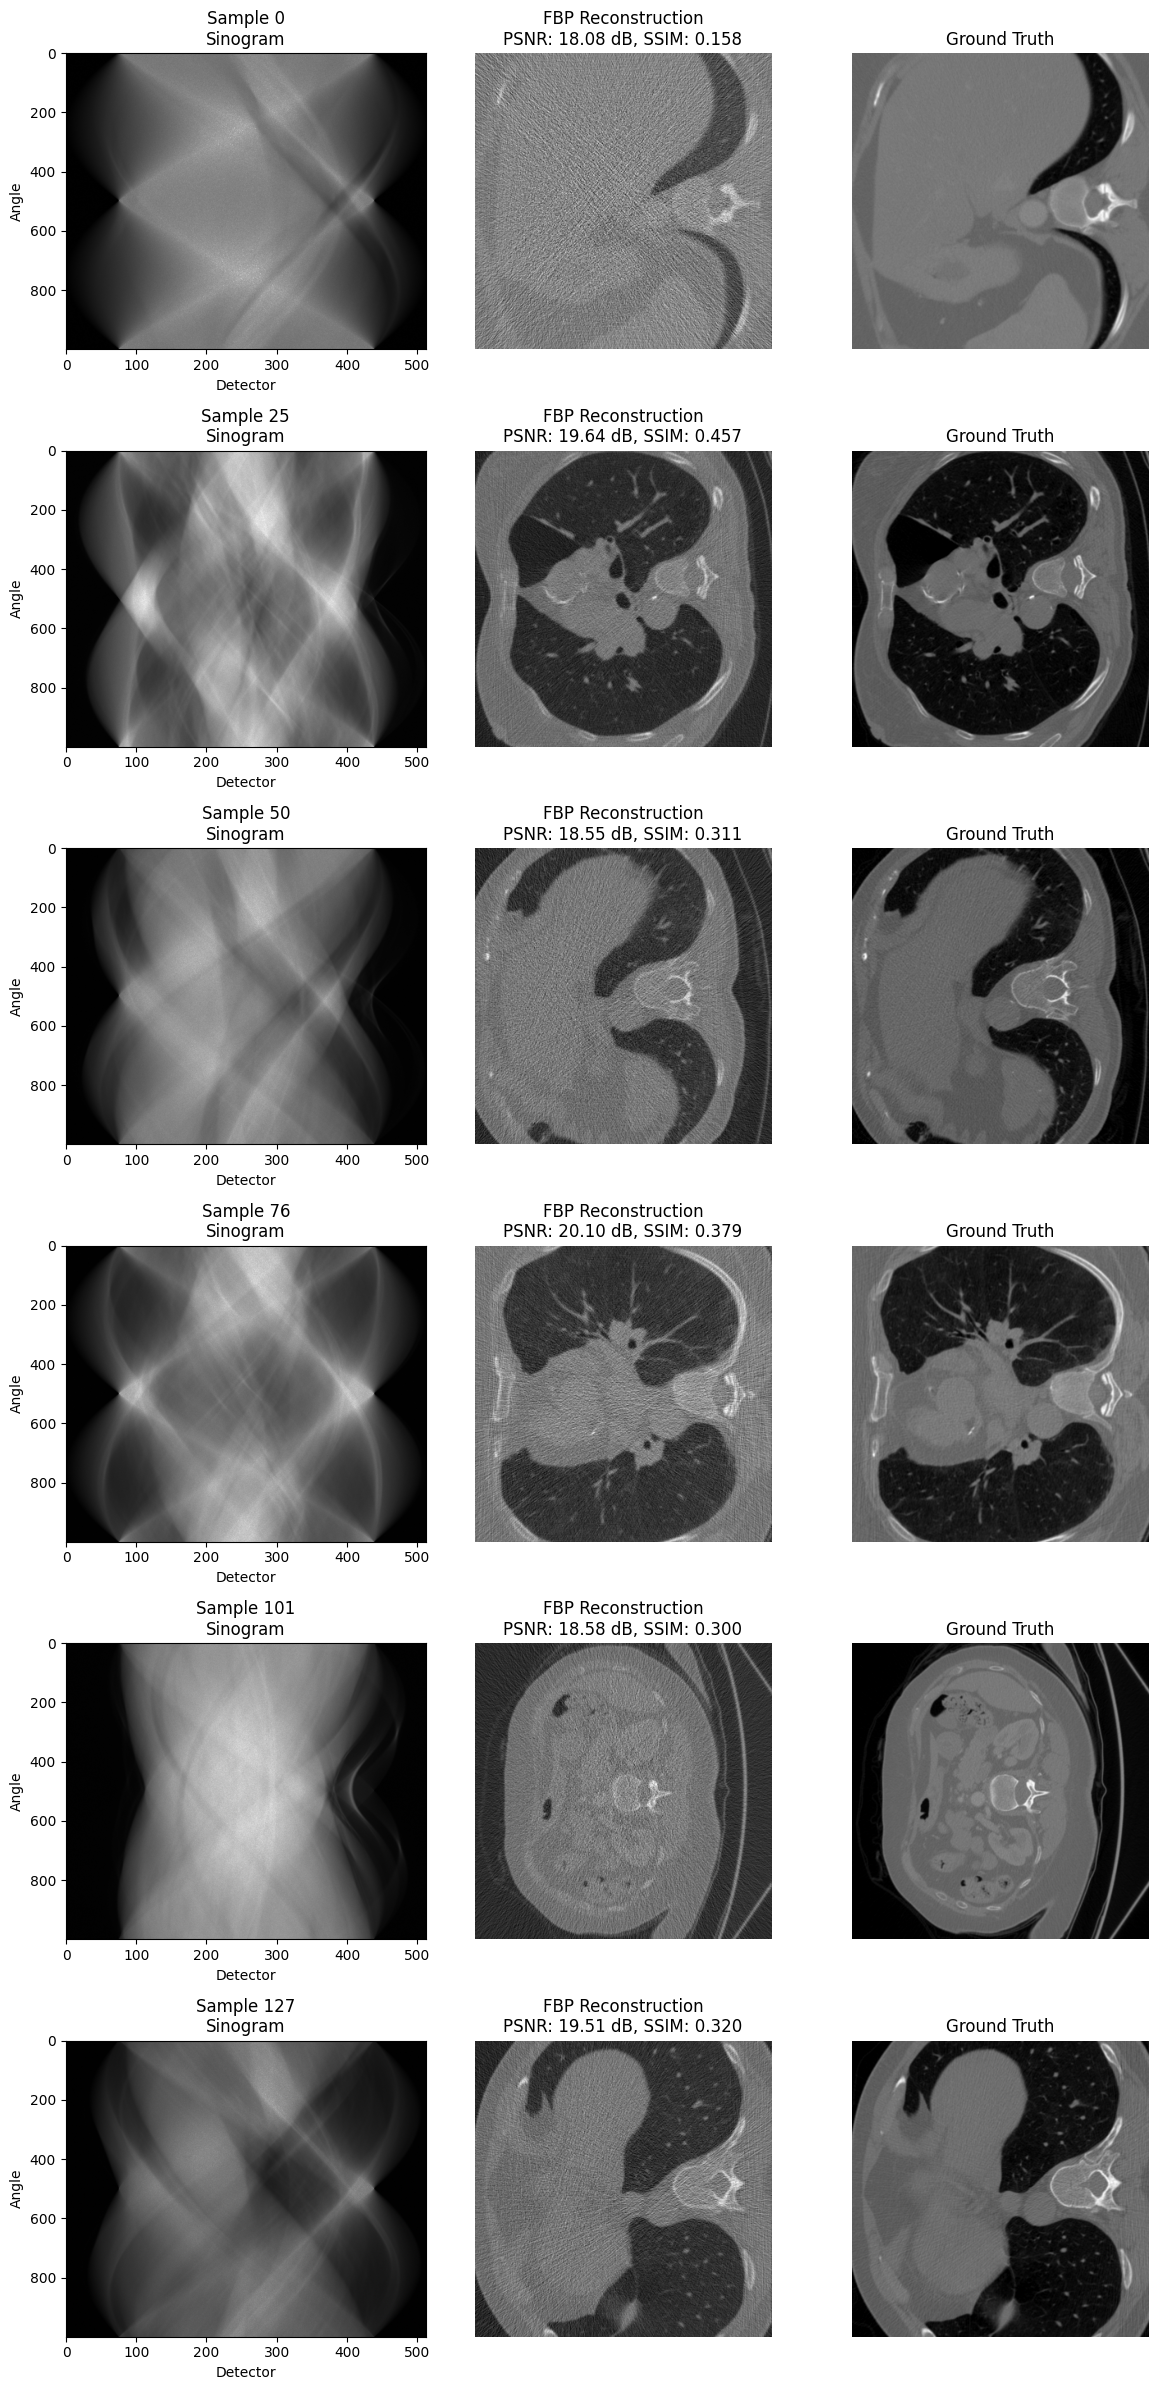

Saved sample reconstructions to: ../data/results/fbp/fbp_sample_reconstructions.png


In [42]:
    # Load and reconstruct a few samples for visualization
num_vis_samples = 6
sample_indices = np.linspace(0, len(df_results)-1, num_vis_samples, dtype=int)

fig, axes = plt.subplots(num_vis_samples, 3, figsize=(12, 4*num_vis_samples))

for plot_idx, sample_idx in enumerate(sample_indices):
    # Get file and local index
    file_idx = int(df_results.iloc[sample_idx]['file_idx'])
    local_idx = int(df_results.iloc[sample_idx]['local_idx'])
    
    # Load data
    with h5py.File(test_obs_files[file_idx], 'r') as f_obs, \
         h5py.File(test_gt_files[file_idx], 'r') as f_gt:
        
        sinogram = f_obs['data'][local_idx].astype(np.float32)
        ground_truth = f_gt['data'][local_idx].astype(np.float32)
    
    # Reconstruct
    reconstructed = fbp_reconstruct(sinogram, filter_name=FBP_CONFIG['filter_name'])
    
    # Normalize
    reconstructed_norm = normalize_image(reconstructed)
    ground_truth_norm = normalize_image(ground_truth)
    
    # Get metrics
    psnr = df_results.iloc[sample_idx]['psnr']
    ssim = df_results.iloc[sample_idx]['ssim']
    
    # Plot sinogram
    axes[plot_idx, 0].imshow(sinogram, cmap='gray', aspect='auto')
    axes[plot_idx, 0].set_title(f'Sample {sample_idx}\nSinogram')
    axes[plot_idx, 0].set_xlabel('Detector')
    axes[plot_idx, 0].set_ylabel('Angle')
    
    # Plot FBP reconstruction
    axes[plot_idx, 1].imshow(reconstructed_norm, cmap='gray')
    axes[plot_idx, 1].set_title(f'FBP Reconstruction\nPSNR: {psnr:.2f} dB, SSIM: {ssim:.3f}')
    axes[plot_idx, 1].axis('off')
    
    # Plot ground truth
    axes[plot_idx, 2].imshow(ground_truth_norm, cmap='gray')
    axes[plot_idx, 2].set_title('Ground Truth')
    axes[plot_idx, 2].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fbp_sample_reconstructions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved sample reconstructions to: {OUTPUT_DIR / 'fbp_sample_reconstructions.png'}")